## Seminar 5

Today we'll start by reproducing the DQN and then try improving it with the tricks we learned on the lecture:
* Target networks
* Double q-learning
* Prioritized experience replay
* Dueling DQN
* Bootstrap DQN

In [46]:
from skimage import color

In [47]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


#If you are running on a server, launch xvfb to record game videos
#Please make sure you have xvfb installed
import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1

# Processing game image (2 pts)

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape
* Converting to grayscale
* Cropping irrelevant image parts

In [48]:
from gym.core import ObservationWrapper
from gym.spaces import Box

from scipy.misc import imresize

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self,env)
        
        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)

    def _observation(self, img):
        """what happens to each observation"""
        
        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size 
        #     (use imresize imported above or any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        gray = 0.2989 * img[:,:,0] + 0.5870 * img[:,:,1] + 0.1140 * img[:,:,2]
        return (imresize(gray, self.img_size)/255.0).astype(np.float32)


In [49]:
import gym
def make_env():
#    env = gym.make("KungFuMasterDeterministic-v0") #create raw env
    env = gym.make("Breakout-v0") #create raw env
    return PreprocessAtari(env) #apply your wrapper

#spawn game instance for tests
env = make_env()

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

obs = env.reset()

[2017-05-21 19:41:24,864] Making new env: Breakout-v0


In [42]:
obs.max()

0.99215686

Formal tests seem fine. Here's an example of what you'll get.


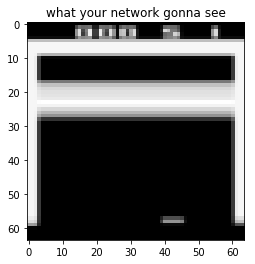

In [50]:
#test observation
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs))>2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(obs) <=1, "convert image pixels to (0,1) range"

print ("Formal tests seem fine. Here's an example of what you'll get.")

plt.title("what your network gonna see")
plt.imshow(obs,interpolation='none',cmap='gray');



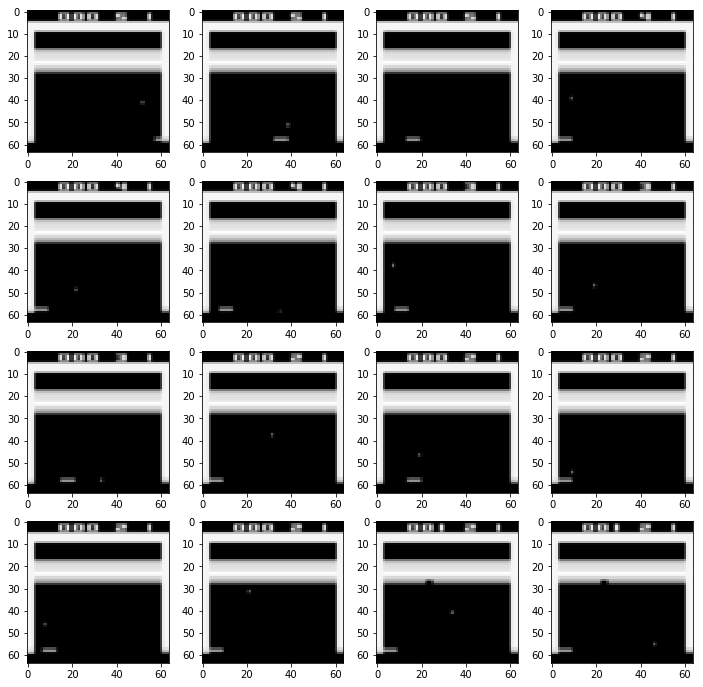

In [51]:
plt.figure(figsize=[12,12])
env.reset()
for i in range(16):
    for _ in range(10):
        new_obs = env.step(env.action_space.sample())[0]
    plt.subplot(4,4,i+1)
    plt.imshow(new_obs,interpolation='none',cmap='gray');




In [52]:
#dispose of the game instance
del env

# Building a DQN (2 pts)
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [53]:
#setup theano/lasagne. Prefer GPU. Fallback to CPU (will print warning)
%env THEANO_FLAGS=floatX=float32

import theano, lasagne
from lasagne.layers import *
from theano import tensor as T

env: THEANO_FLAGS=floatX=float32


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

[2017-05-21 19:41:53,377] The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5105)


In [54]:
#observation
observation_layer = InputLayer((None,)+observation_shape) #game image, [batch,64,64]

In [55]:
#4-tick window over images
from agentnet.memory import WindowAugmentation

prev_wnd = InputLayer((None,4)+observation_shape) #window size [batch,4,64,64]

new_wnd = WindowAugmentation(observation_layer, prev_wnd)

assert new_wnd.output_shape == (None, 4, 64, 64) #if you changed img size, remove assert

In [ ]:
from lasagne.nonlinearities import elu,tanh,softmax,rectify

<network body, growing from new_wnd. several conv layers or something similar would do>
        
dense = <final dense layer with 256 neurons>

In [ ]:
#qvalues layer
qvalues_layer = <a dense layer that predicts q-values>

assert qvalues_layer.nonlinearity is not rectify

In [ ]:
#sample actions proportionally to policy_layer
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)


### Define agent
Here you will need to declare how your agent works

* `observation_layers` and `action_layers` are the input and output of agent in MDP.
* `policy_estimators` must contain whatever you need for training
 * In our case, that's `qvalues_layer`, but you'll need to add more when implementing target network.
* agent_states contains our frame buffer. 
 * The code `{new_wnd:prev_wnd}` reads as "`new_wnd becomes prev_wnd next turn`"

In [ ]:
from agentnet.agent import Agent
#agent
agent = Agent(observation_layers=<...>,
              policy_estimators=<...>,
              action_layers=<...>,
              agent_states={new_wnd:prev_wnd},)


# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [ ]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, n_games=16) #16 parallel game sessions


In [ ]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(5)

print('actions:')
print(action_log[0])
print("rewards")
print(reward_log[0])

In [ ]:
#load first sessions (this function calls interact and remembers sessions)
SEQ_LENGTH=10 #sub-session length
pool.update(SEQ_LENGTH)

# Q-learning

We train our agent based on sessions it has played in `pool.update(SEQ_LENGTH)`

To do so, we first obtain sequences of observations, rewards, actions, q-values, etc.

Actions and rewards have shape `[n_games,seq_length]`, q-values are `[n_games,seq_length,n_actions]`

In [ ]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay

actions,rewards,is_alive = replay.actions[0],replay.rewards,replay.is_alive

_,_,_,_,qvalues = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)

assert actions.ndim == rewards.ndim == is_alive.ndim == 2, "actions, rewards and is_alive must have shape [batch,time]"
assert qvalues.ndim == 3, "q-values must have shape [batch,time,n_actions]"


In [ ]:
#compute V(s) as Qvalues of best actions. 
#For homework assignment, you will need to use target net 
#or special double q-learning objective here

state_values_target = <compute V(s) 2d tensor by taking T.argmax of qvalues over correct axis>

assert state_values_target.eval().shape = qvalues.eval().shape[:2]

In [ ]:
from agentnet.learning.generic import get_n_step_value_reference

# get reference Q-values via Q-learning algorithm
reference_qvalues = get_n_step_value_reference(
    state_values=state_values_target,
    rewards=rewards/100.,
    is_alive=is_alive,
    n_steps=10,
    gamma_or_gammas=0.99,
)

#consider it constant
from theano.gradient import disconnected_grad
reference_qvalues = disconnected_grad(reference_qvalues)

In [ ]:
# get predicted Q-values for committed actions by both current and target networks
from agentnet.learning.generic import get_values_for_actions
action_qvalues = get_values_for_actions(qvalues, actions)


In [ ]:
#loss for Qlearning = 
#(Q(s,a) - (r+ gamma*r' + gamma^2*r'' + ...  +gamma^10*Q(s_{t+10},a_max)))^2

elwise_mse_loss = <mean squared error between action qvalues and reference qvalues>

#mean over all batches and time ticks
loss = (elwise_mse_loss*is_alive).mean()

In [ ]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = <get all trainable params>
weights

In [ ]:
# Compute weight updates
updates = <your favorite optimizer>

#compile train function
train_step = theano.function([],loss,updates=updates)

# Demo run
as usual...

In [ ]:
action_layer.epsilon.set_value(0.05)
untrained_reward = np.mean(pool.evaluate(save_path="./records",
                                         record_video=True))

In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [ ]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {}
loss,reward_per_tick,reward =0,0,0

In [ ]:
from tqdm import trange
from IPython.display import clear_output


for i in trange(150000):    
    
    ##update agent's epsilon (in e-greedy policy)
    current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/20000.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))

    #play
    pool.update(SEQ_LENGTH)

    #train
    loss = 0.95*loss + 0.05*train_step()    
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        reward_per_tick = 0.95*reward_per_tick + 0.05*pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\tloss=%.3f\treward/tick=%.3f"%(epoch_counter,
                                                               current_epsilon,
                                                               loss,
                                                               reward_per_tick))
        
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        action_layer.epsilon.set_value(0.05)
        reward = 0.95*reward + 0.05*np.mean(pool.evaluate(record_video=False))
        action_layer.epsilon.set_value(np.float32(current_epsilon))
        
        rewards[epoch_counter] = reward
        
        clear_output(True)
        plt.plot(*zip(*sorted(rewards.items(),key=lambda (t,r):t)))
        plt.show()
        

    
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results
 * Here we plot learning curves and sample testimonials

In [ ]:
import pandas as pd
plt.plot(*zip(*sorted(rewards.items(),key=lambda k:k[0])))

In [ ]:
from agentnet.utils.persistence import save,load
save(action_layer,"pacman.pcl")

In [ ]:
action_layer.epsilon.set_value(0.05)
rw = pool.evaluate(n_games=20,save_path="./records",record_video=False)
print("mean session score=%f.5"%np.mean(rw))

In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

## Assignment part 1 (2 pts)

We'll start by implementing target network to stabilize training.

There are two ways to do so: 


__1)__ Manually write lasagne network, or clone it via [one of those methods](https://github.com/Lasagne/Lasagne/issues/720).

You will need to implement loading weights from original network to target network.

We recommend thoroughly debugging your code on simple tests before applying it in atari dqn.

__2)__ Use pre-build functionality from [here](http://agentnet.readthedocs.io/en/master/modules/target_network.html)

```
from agentnet.target_network import TargetNetwork
target_net = TargetNetwork(qvalues_layer)
old_qvalues = target_net.output_layers

#agent's policy_estimators must now become (qvalues,old_qvalues)

_,_,_,_,(qvalues,old_qvalues) = agent.get_sessions(...) #replaying experience


target_net.load_weights()#loads weights, so target network is now exactly same as main network

target_net.load_weights(0.01)# w_target = 0.99*w_target + 0.01*w_new
```

## Assignment part 2 (4+ pts)

Implement and train double q-learning.

This task contains of
* Implementing __double q-learning__ or __dueling q-learning__ or both (see tips below)
* Training a network till convergence
  * Full points will be awwarded if your network gets average score of >=10 (see "evaluating results")
  * Higher score = more points as usual
  * If you're running out of time, it's okay to submit a solution that hasn't converged yet and updating it when it converges. _Lateness penalty will not increase for second submission_, so submitting first one in time gets you no penalty.


#### Tips:
* Implementing __double q-learning__ shouldn't be a problem if you've already have target networks in place.
  * As one option, use `get_values_for_actions(<some q-values tensor3>,<some indices>)`.
  * You will probably need `T.argmax` to select best actions
  * Here's an original [article](https://arxiv.org/abs/1509.06461)

* __Dueling__ architecture is also quite straightforward if you have standard DQN.
  * You will need to change network architecture, namely the q-values layer
  * It must now contain two heads: V(s) and A(s,a), both dense layers
  * You should then add them up via elemwise sum layer or a [custom](http://lasagne.readthedocs.io/en/latest/user/custom_layers.html) layer.
  * Here's an [article](https://arxiv.org/pdf/1511.06581.pdf)
  
Here's a template for your convenience:

In [ ]:
from lasagne.layers import *
class DuelingQvaluesLayer(MergeLayer):
    def get_output_for(self, inputs,**tags):
        V,A = inputs        
        return <add them up :)>
    
    def get_output_shape_for(self, input_shapes,**tags):
        V_shape,A_shape = input_shapes
        assert len(V_shape) == 2 and V_shape[-1] ==1, "V layer (first param) shape must be [batch,tick,1]"
        return A_shape #shape of q-values is same as predicted advantages

In [ ]:
#mock-up tests
import theano.tensor as T
v_tensor = -T.arange(10).reshape((10,1))
V = InputLayer((None,1), v_tensor)

a_tensor = T.arange(30).reshape((10,3))
A = InputLayer((None,1), a_tensor)

Q = DuelingQvaluesLayer([V,A])

In [ ]:
import numpy as np
assert np.allclose(get_output(Q).eval(), (v_tensor+a_tensor).eval())
print ("looks good")

## Bonus II (5+ pts): Prioritized experience replay

In this section, you're invited to implement prioritized experience replay

* You will probably need to provide a custom data structure
* Once pool.update is called, collect the pool.experience_replay.observations, actions, rewards and is_alive and store them in your data structure
* You can now sample such transitions in proportion to the error (see [article](https://arxiv.org/abs/1511.05952)) for training.

It's probably more convenient to explicitly declare inputs for "sample observations", "sample actions" and so on to plug them into q-learning.

Prioritized (and even normal) experience replay should greatly reduce amount of game sessions you need to play in order to achieve good performance. 

While it's effect on runtime is limited for atari, more complicated envs (further in the course) will certainly benefit for it.

Prioritized experience replay only supports off-policy algorithms, so pls enforce `n_steps=1` in your q-learning reference computation (default is 10).